In [55]:
import xarray as xr
import rioxarray as rxr
import pyproj
import geopandas as gpd

In [105]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('./ucrb_hcdn_co_polygons_final.json')
hcdn_boundaries=hcdn_boundaries.to_crs(lcc_proj)


In [82]:
pet_ds = rxr.open_rasterio('../../data/pevap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\rioxarray\_io.py:851: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [106]:
pet_ds = pet_ds.rio.write_crs(lcc_proj)
pet_ds_clipped = pet_ds.rio.clip(hcdn_boundaries.geometry)
pet_ds_masked=pet_ds_clipped.where(pet_ds_clipped['pevap']!=9.96921e+36)
# convert to mm equivalent
pet_ds_masked['pevap'] = pet_ds_masked['pevap']
pet_ds_masked['pevap'].attrs['units']='mm'

In [107]:
pet_ds_masked

<xarray.Dataset>
Dimensions:            (time: 530, y: 12, x: 7)
Coordinates:
  * y                  (y) float64 3.571e+06 3.538e+06 ... 3.246e+06 3.214e+06
  * x                  (x) float64 5.519e+06 5.551e+06 ... 5.681e+06 5.713e+06
  * time               (time) object 1979-01-01 00:00:00 ... 2023-02-01 00:00:00
    spatial_ref        int32 0
    Lambert_Conformal  int32 0
Data variables:
    pevap              (time, y, x) float32 nan nan nan 0.07414 ... nan nan nan
Attributes: (12/15)
    centerlat:      50
    centerlon:      -107
    comments:       
    Conventions:    CF-1.2
    dataset_title:  NCEP North American Regional Reanalysis (NARR)
    history:        created 2016/04/12 by NOAA/ESRL/PSD
    ...             ...
    platform:       Model
    References:     
    source:         http://www.emc.ncep.noaa.gov/mmb/rreanl/index.html
    standardpar1:   50
    standardpar2:   50.000001
    title:          NARR Monthly Means

In [123]:
pet_ds_masked['WY'] = pet_ds_masked.time.dt.year.where(pet_ds_masked.time.dt.month<10,pet_ds_masked.time.dt.year+1)
pet_wy_ds_mean = pet_ds_masked.where(pet_ds_masked['WY']!=2023).groupby('WY').sum() #.mean(dim='x').mean(dim='y')

In [121]:
pet_wy_ds_mean

<xarray.Dataset>
Dimensions:            (WY: 44)
Coordinates:
  * WY                 (WY) float64 1.979e+03 1.98e+03 ... 2.021e+03 2.022e+03
    spatial_ref        int32 0
    Lambert_Conformal  int32 0
Data variables:
    pevap              (WY) float32 0.9585 1.203 1.33 ... 1.267 1.197 1.165

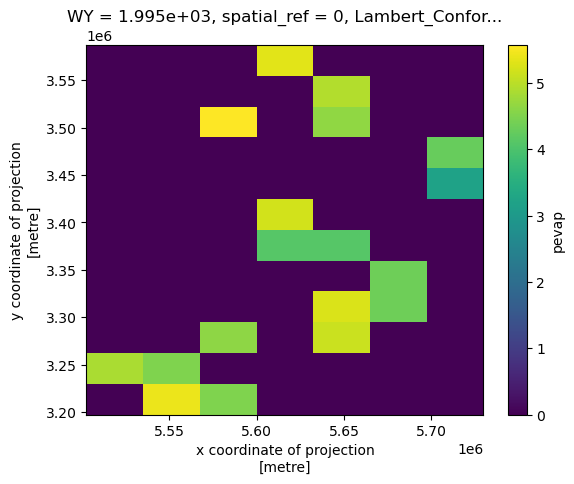

In [127]:
pet_wy_ds_mean['pevap'].sel(WY=1995).plot()

In [ ]:
def modify_xarray_timezone(ds, source_tz, target_tz):
    ds = ds.copy()
    time_utc = ds['time'].to_index().tz_localize(source_tz)
    tz_corrected = time_utc.tz_convert(target_tz).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({f'time ({target_tz})': tz_corrected})
    ds.coords.update({f'time ({source_tz})': ds['time'].to_index()})
    ds = ds.assign_coords({
        'time': ds[f'time ({target_tz})'].values
    })
    return ds